# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Imports

import pickle
import random
import numpy as np
import scipy
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.contrib.layers import flatten

from PIL import Image
from PIL import ImageEnhance

from sklearn.utils import shuffle
#from sklearn.preprocessing import normalize

In [2]:
# constants

EPOCHS = 30
BATCH_SIZE = 50
LEARNING_RATE = 0.001

MODEL_FOLDER = "./networks_backup/"
MODEL_PATH = MODEL_FOLDER + "exp3"

NETWORK_TO_RESTORE = MODEL_FOLDER + "exp3_after_epoch_30"

In [3]:
# toolkit

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def print_random_image(dataset, labelset):
    index = random.randint(0, len(dataset))
    image = dataset[index].squeeze()
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    print(labelset[index])
    gray = rgb2gray(image)
    plt.figure(figsize=(5,5))
    plt.imshow(gray, cmap="gray")
    
def print_random_greyscale(dataset, labelset):
    index = random.randint(0, len(dataset))
    rgb = dataset[index]
    gray = rgb2gray(rgb)

    plt.figure(figsize=(1,1))
    plt.imshow(gray, cmap="gray")
    print(labelset[index])
    
def print_image(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img)
    
def print_sign_occurrences(labelset):
    sign_occurrences = np.zeros((n_classes))
    for label in labelset:
        sign_occurrences[label] += 1
    for i in range(len(sign_occurrences)):
        print(str(i) + ": " + str(sign_occurrences[i]))
    plt.plot(sign_occurrences)
    plt.ylabel("occurrences")
    plt.show()
    
def increase_contrast(rgb):
    image_rgb_pil = Image.fromarray(rgb)
    contrast = ImageEnhance.Contrast(image_rgb_pil)
    image_rgb_pil = contrast.enhance(2)
    rgb = np.asarray(image_rgb_pil)
    return rgb

def normalize(arr):
    # from: http://stackoverflow.com/questions/7422204/intensity-normalization-of-image-using-pythonpil-speed-issues
    
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (1.0/(maxval-minval))
    return arr

def greyscale_and_normalize(rgb):
    image_rgb_pil = Image.fromarray(rgb)
    contrast = ImageEnhance.Contrast(image_rgb_pil)
    image_rgb_pil = contrast.enhance(2)
    rgb = np.asarray(image_rgb_pil)
    return normalize(rgb2gray(rgb)).flatten()

def greyscale_and_normalize_dataset(dataset):
    normalized_dataset = np.ndarray((len(dataset), image_shape[0] * image_shape[1]))
    for i in range(len(dataset)):
        np.copyto(normalized_dataset[i], greyscale_and_normalize(dataset[i]), casting='unsafe')
    return normalized_dataset

def barchart(xlabels, y):
    width = 1/1.5
    axes = plt.gca()
    axes.set_ylim([0.0, 1.0])
    plt.bar(range(len(xlabels)), y, width, align='center', color="blue")
    plt.xticks(range(len(xlabels)), xlabels)
    plt.show()

def topk_to_barcharts(topk):
    for i in range(len(topk.values)):
        x = [str(index) for index in topk.indices[i]] 
        y = topk.values[i]
        barchart(x, y)

### ----------------------------------------------------------------------------------------------------------------

def preprocess(rgb_arr):
    return normalize(rgb_arr)

def read_png_and_copy_to_dataset(path, dataset):
    image_rgb_pil = Image.open(path).convert('RGB')
    #contrast = ImageEnhance.Contrast(image_rgb_pil)
    #image_rgb_pil = contrast.enhance(2)
    image_rgb = np.asarray(image_rgb_pil)
    image_rgb = preprocess(image_rgb)
    print_image(image_rgb)
    np.copyto(dataset, image_rgb, casting='unsafe')

In [4]:
# Load pickled data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_valid = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

0: 180.0
1: 1980.0
2: 2010.0
3: 1260.0
4: 1770.0
5: 1650.0
6: 360.0
7: 1290.0
8: 1260.0
9: 1320.0
10: 1800.0
11: 1170.0
12: 1890.0
13: 1920.0
14: 690.0
15: 540.0
16: 360.0
17: 990.0
18: 1080.0
19: 180.0
20: 300.0
21: 270.0
22: 330.0
23: 450.0
24: 240.0
25: 1350.0
26: 540.0
27: 210.0
28: 480.0
29: 240.0
30: 390.0
31: 690.0
32: 210.0
33: 599.0
34: 360.0
35: 1080.0
36: 330.0
37: 180.0
38: 1860.0
39: 270.0
40: 300.0
41: 210.0
42: 210.0


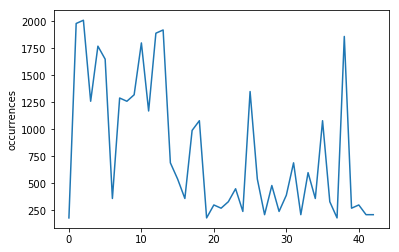

In [6]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline

print_sign_occurrences(y_train)

7


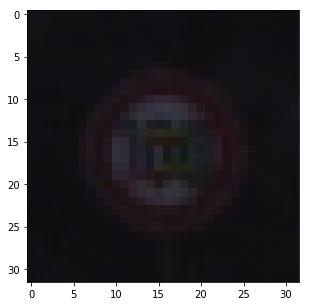

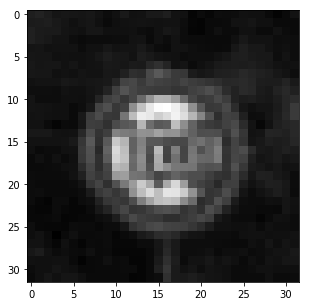

In [7]:
# print an image from the training set, with its label
print_random_image(X_train, y_train)

# print a greyscale image from the training set, with its label
#print_random_greyscale(X_train, y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### Model Architecture

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #x = tf.reshape(x, (-1, 32, 32, 1))
    
    # 1x1x10 filter
    filter1_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 3, 10), mean = mu, stddev = sigma), name='filter1_W')
    filter1_b = tf.Variable(tf.zeros(10), name='filter1_b')
    filter1   = tf.nn.conv2d(x, filter1_W, strides=[1, 1, 1, 1], padding='VALID') + filter1_b
    
    filter1 = tf.nn.relu(filter1)
    
    # 1x1x3 filter
    filter2_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 10, 3), mean = mu, stddev = sigma), name='filter2_W')
    filter2_b = tf.Variable(tf.zeros(3), name='filter2_b')
    filter2   = tf.nn.conv2d(filter1, filter2_W, strides=[1, 1, 1, 1], padding='VALID') + filter2_b
    
    filter2 = tf.nn.relu(filter2)
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma), name='conv1_W')
    conv1_b = tf.Variable(tf.zeros(6), name='conv1_b')
    conv1   = tf.nn.conv2d(filter2, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name='conv2_W')
    conv2_b = tf.Variable(tf.zeros(16), name='conv2_b')
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name='fc1_W')
    fc1_b = tf.Variable(tf.zeros(120), name='fc1_b')
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name='fc2_W')
    fc2_b  = tf.Variable(tf.zeros(84), name='fc2_b')
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma), name='fc3_W')
    fc3_b  = tf.Variable(tf.zeros(43), name='fc3_b')
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

logits = LeNet(x, keep_prob)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y))
opt = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def evaluate(X_data, y_data, batch_size=BATCH_SIZE):
    num_examples = len(X_data)
    total_accuracy = 0.0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        end = offset + batch_size
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def train_model(X_train, y_train, X_valid, y_valid, model_path, epochs=EPOCHS, batch_size=BATCH_SIZE):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)
        print("Target model name prefix is " + MODEL_PATH)
        print("Training in " + str(epochs) + " epochs, with batch size " + str(batch_size) + "...")
        for i in range(epochs):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, batch_size):
                 end = offset + batch_size
                 batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                 sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

            training_accuracy = evaluate(X_train, y_train, batch_size)
            validation_accuracy = evaluate(X_valid, y_valid, batch_size)
            print("EPOCH {} ...".format(i+1))
            print("Training accuracy = {:.3f}".format(training_accuracy))
            print("Validation accuracy = {:.3f}".format(validation_accuracy))
            saver.save(sess, str(model_path) + '_after_epoch_' + str(i+1))
            print("Model saved")
            print()


In [9]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

X_train_preprocessed = [preprocess(rgb) for rgb in X_train]
X_valid_preprocessed = [preprocess(rgb) for rgb in X_valid]
X_test_preprocessed = [preprocess(rgb) for rgb in X_test]


8
12


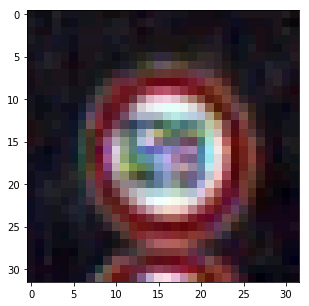

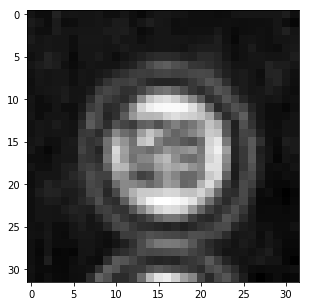

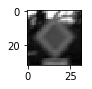

In [10]:
# print an image from the training set, with its label
print_random_image(X_train_preprocessed, y_train)

# print a greyscale image from the training set, with its label
print_random_greyscale(X_train_preprocessed, y_train)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [20]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

train_model(X_train_preprocessed, y_train, X_valid_preprocessed, y_valid, MODEL_PATH, EPOCHS, BATCH_SIZE)

Target model name prefix is ./networks_backup/exp3
Training in 30 epochs, with batch size 50...
EPOCH 1 ...
Training accuracy = 0.426
Validation accuracy = 0.365
Model saved

EPOCH 2 ...
Training accuracy = 0.564
Validation accuracy = 0.514
Model saved

EPOCH 3 ...
Training accuracy = 0.721
Validation accuracy = 0.674
Model saved

EPOCH 4 ...
Training accuracy = 0.843
Validation accuracy = 0.788
Model saved

EPOCH 5 ...
Training accuracy = 0.911
Validation accuracy = 0.848
Model saved

EPOCH 6 ...
Training accuracy = 0.947
Validation accuracy = 0.878
Model saved

EPOCH 7 ...
Training accuracy = 0.967
Validation accuracy = 0.895
Model saved

EPOCH 8 ...
Training accuracy = 0.974
Validation accuracy = 0.897
Model saved

EPOCH 9 ...
Training accuracy = 0.980
Validation accuracy = 0.903
Model saved

EPOCH 10 ...
Training accuracy = 0.983
Validation accuracy = 0.921
Model saved

EPOCH 11 ...
Training accuracy = 0.989
Validation accuracy = 0.921
Model saved

EPOCH 12 ...
Training accuracy = 

In [11]:
# evaluate test set

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, NETWORK_TO_RESTORE)
    prediction_accuracy = evaluate(X_test_preprocessed, y_test)
    print("Test accuracy = {:.3f}".format(prediction_accuracy))

Test accuracy = 0.934


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

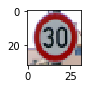

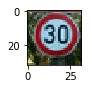

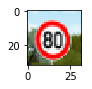

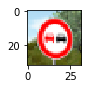

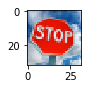

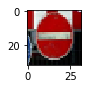

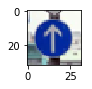

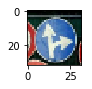

In [12]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

X_own_test = np.ndarray((8, 32, 32, 3))
y_own_test = np.array([1, 1, 5, 9, 14, 17, 35, 36])
    
read_png_and_copy_to_dataset("signs_small/1_speed_limit_30_2_32x32.png", X_own_test[0]) 
read_png_and_copy_to_dataset("signs_small/1_speed_limit_30_32x32.png", X_own_test[1])
read_png_and_copy_to_dataset("signs_small/5_speed_limit_80_32x32.PNG", X_own_test[2])
read_png_and_copy_to_dataset("signs_small/9_no_passing_32x32.PNG", X_own_test[3])
read_png_and_copy_to_dataset("signs_small/14_stop_32x32.PNG", X_own_test[4])
read_png_and_copy_to_dataset("signs_small/17_no_entry_32x32.PNG", X_own_test[5])
read_png_and_copy_to_dataset("signs_small/35_ahead_only_32x32.PNG", X_own_test[6])
read_png_and_copy_to_dataset("signs_small/36_go_straight_or_right_32x32.PNG", X_own_test[7])



### Predict the Sign Type for Each Image

In [13]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()

predictions = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, NETWORK_TO_RESTORE)
    
    result = sess.run(predictions, feed_dict={x: X_own_test, keep_prob: 1.0})

    print("Predictions:", result)

Predictions: [ 1  1  5  9 14 17 35 36]


### Analyze Performance

In [14]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, NETWORK_TO_RESTORE)
    prediction_accuracy = evaluate(X_own_test, y_own_test)
    print("Test accuracy on new images = {:.3f}".format(prediction_accuracy))

Test accuracy on new images = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

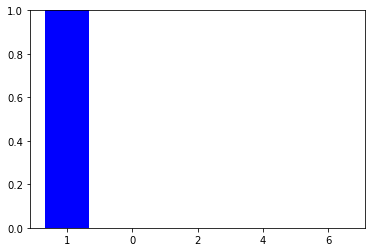

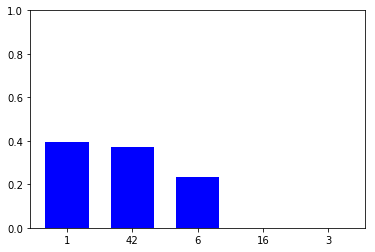

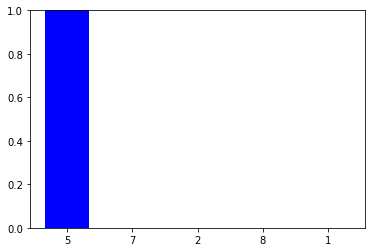

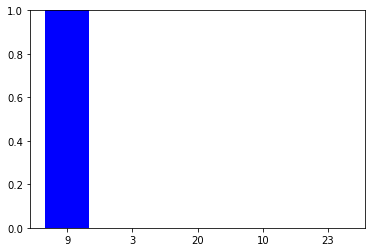

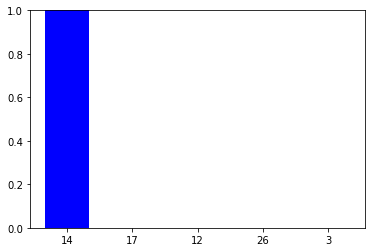

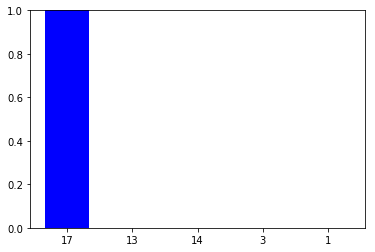

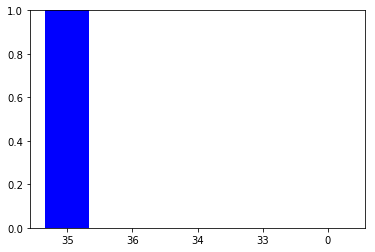

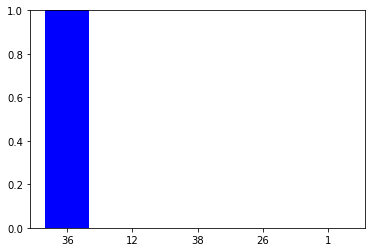

Top 5 Softmax: TopKV2(values=array([[  1.00000000e+00,   4.53324037e-14,   7.02010732e-18,
          1.49466978e-22,   1.39107637e-23],
       [  3.93223763e-01,   3.73215258e-01,   2.31457427e-01,
          9.63380735e-04,   6.71494519e-04],
       [  9.99999523e-01,   3.44853390e-07,   1.04538749e-07,
          8.45318282e-13,   4.33433644e-13],
       [  1.00000000e+00,   7.26067654e-27,   7.04385856e-30,
          3.62123495e-31,   5.19963822e-32],
       [  1.00000000e+00,   2.93202369e-08,   2.39069944e-11,
          2.54456829e-13,   1.72907144e-15],
       [  1.00000000e+00,   3.25687475e-13,   1.20409715e-15,
          6.23421982e-26,   4.80705982e-26],
       [  1.00000000e+00,   3.62982450e-23,   3.74570090e-25,
          7.73099830e-31,   0.00000000e+00],
       [  9.99992728e-01,   7.28604664e-06,   2.20020695e-08,
          1.43787217e-13,   4.40017353e-15]], dtype=float32), indices=array([[ 1,  0,  2,  4,  6],
       [ 1, 42,  6, 16,  3],
       [ 5,  7,  2,  8,  1],
   

In [15]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()

predictions = tf.nn.softmax(logits)
top_5 = tf.nn.top_k(predictions, k=5)

with tf.Session() as sess:
    saver.restore(sess, NETWORK_TO_RESTORE)
    
    result = sess.run(top_5, feed_dict={x: X_own_test, keep_prob: 1.0})
    
    topk_to_barcharts(result)

    print("Top 5 Softmax:", result)

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [38]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = permanent_session.run(tf_activation, feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
       

Loading session...
Done.


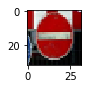

In [81]:
# get tf variables
saver = tf.train.Saver()
print("Loading session...")
permanent_session = tf.Session()
saver.restore(permanent_session, NETWORK_TO_RESTORE)

image_input = np.ndarray((1, 32, 32, 3))

#read_png_and_copy_to_dataset("signs_small/1_speed_limit_30_2_32x32.png", image_input[0]) 
#read_png_and_copy_to_dataset("signs_small/1_speed_limit_30_32x32.png", image_input[0])
#read_png_and_copy_to_dataset("signs_small/5_speed_limit_80_32x32.PNG", image_input[0])
#read_png_and_copy_to_dataset("signs_small/9_no_passing_32x32.PNG", image_input[0])
#read_png_and_copy_to_dataset("signs_small/14_stop_32x32.PNG", image_input[0])
read_png_and_copy_to_dataset("signs_small/17_no_entry_32x32.PNG", image_input[0])
#read_png_and_copy_to_dataset("signs_small/35_ahead_only_32x32.PNG", image_input[0])
#read_png_and_copy_to_dataset("signs_small/36_go_straight_or_right_32x32.PNG", image_input[0])


print("Done.")


In [46]:
print("Printing all variable names...")

global_variables = tf.global_variables()
for i in range(len(global_variables)):
    print(str(i) + ": " + str(global_variables[i].name))

Printing all variable names...
0: filter1_W:0
1: filter1_b:0
2: filter2_W:0
3: filter2_b:0
4: conv1_W:0
5: conv1_b:0
6: conv2_W:0
7: conv2_b:0
8: fc1_W:0
9: fc1_b:0
10: fc2_W:0
11: fc2_b:0
12: fc3_W:0
13: fc3_b:0
14: beta1_power:0
15: beta2_power:0
16: filter1_W/Adam:0
17: filter1_W/Adam_1:0
18: filter1_b/Adam:0
19: filter1_b/Adam_1:0
20: filter2_W/Adam:0
21: filter2_W/Adam_1:0
22: filter2_b/Adam:0
23: filter2_b/Adam_1:0
24: conv1_W/Adam:0
25: conv1_W/Adam_1:0
26: conv1_b/Adam:0
27: conv1_b/Adam_1:0
28: conv2_W/Adam:0
29: conv2_W/Adam_1:0
30: conv2_b/Adam:0
31: conv2_b/Adam_1:0
32: fc1_W/Adam:0
33: fc1_W/Adam_1:0
34: fc1_b/Adam:0
35: fc1_b/Adam_1:0
36: fc2_W/Adam:0
37: fc2_W/Adam_1:0
38: fc2_b/Adam:0
39: fc2_b/Adam_1:0
40: fc3_W/Adam:0
41: fc3_W/Adam_1:0
42: fc3_b/Adam:0
43: fc3_b/Adam_1:0


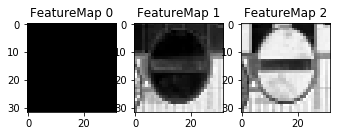

In [82]:
layer = sess.graph.get_tensor_by_name("Relu_1:0") 
outputFeatureMap(image_input, layer)

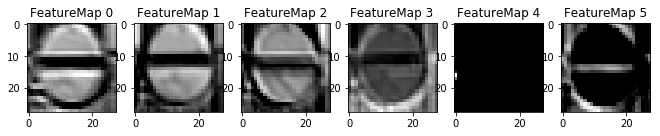

In [83]:
layer = sess.graph.get_tensor_by_name("Relu_2:0") 
outputFeatureMap(image_input, layer)

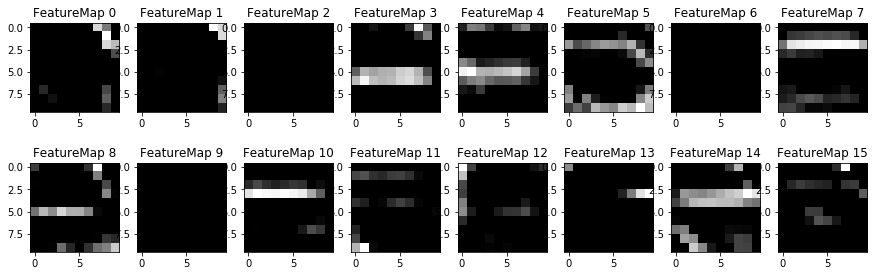

In [84]:
layer = sess.graph.get_tensor_by_name("Relu_3:0") 
outputFeatureMap(image_input, layer)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 